---
# Определение перспективного тарифа для телеком компании
---

## Описание проекта

Клиентам компании "Мегалайн" предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

##### Описание тарифов
__Тариф «Смарт»__
1. Ежемесячная плата: 550 рублей
1. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
1. Стоимость услуг сверх тарифного пакета:
    + минута разговора: 3 рубля
    + сообщение: 3 рубля
    + 1 Гб интернет-трафика: 200 рублей
    
__Тариф «Ультра»__
1. Ежемесячная плата: 1950 рублей
1. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
1. Стоимость услуг сверх тарифного пакета:
    + минута разговора: 1 рубль
    + сообщение: 1 рубль
    + 1 Гб интернет-трафика: 150 рублей

## 1. Описание данных

Таблица __users__ (информация о пользователях):
+ user_id — уникальный идентификатор пользователя
+ first_name — имя пользователя
+ last_name — фамилия пользователя
+ age — возраст пользователя (годы)
+ reg_date — дата подключения тарифа (день, месяц, год)
+ churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
+ city — город проживания пользователя
+ tariff — название тарифного плана

Таблица __calls__ (информация о звонках):
+ id — уникальный номер звонка
+ call_date — дата звонка
+ duration — длительность звонка в минутах
+ user_id — идентификатор пользователя, сделавшего звонок

Таблица __messages__ (информация о сообщениях):
+ id — уникальный номер сообщения
+ message_date — дата сообщения
+ user_id — идентификатор пользователя, отправившего сообщение

Таблица __internet__ (информация об интернет-сессиях):
+ id — уникальный номер сессии
+ mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
+ session_date — дата интернет-сессии
+ user_id — идентификатор пользователя

Таблица __tariffs__ (информация о тарифах):
+ tariff_name — название тарифа
+ rub_monthly_fee — ежемесячная абонентская плата в рублях
+ minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
+ messages_included — количество сообщений в месяц, включённых в абонентскую плату
+ mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
+ rub_per_minute — стоимость минуты разговора сверх тарифного пакета
+ rub_per_message — стоимость отправки сообщения сверх тарифного пакета
+ rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 ГБ = 1024 МБ)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
users_data = pd.read_csv('/datasets/users.csv')
calls_data = pd.read_csv('/datasets/calls.csv')
sms_data = pd.read_csv('/datasets/messages.csv')
internet_data = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
users_data.info()
users_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


+ Обработка пропусков в столбце __'churn_date'__ не требуется
+ В столбцах __'reg_date'__ и __'churn_date'__ нужно сменить тип данных на _datetime_

In [4]:
calls_data.info()
calls_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


+ В столбце __'reg_date'__ нужно сменить тип данных на _datetime_
+ В столбце __'duration'__ необходимо все значения округлить до ближайшего целого в большую сторону

In [5]:
sms_data.info()
sms_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


+ В столбце __'message_date'__ нужно сменить тип данных на _datetime_

In [6]:
internet_data.info()
internet_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


+ В столбце __'session_date'__ нужно сменить тип данных на _datetime_

In [7]:

tariffs.columns = ['messages_included', 'mb_per_month_included',
                   'minutes_included', 'rub_monthly_fee', 'rub_per_gb',
                   'rub_per_message', 'rub_per_minute', 'tariff']
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## 2. Подготовка данных

### Изменение типов данных

In [9]:
def to_datetype(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
    
to_datetype(users_data, 'churn_date')
to_datetype(users_data, 'reg_date')
to_datetype(calls_data, 'call_date')
to_datetype(sms_data, 'message_date')
to_datetype(internet_data, 'session_date')

sms_data['month'] = sms_data['message_date'].dt.month
calls_data['month'] = calls_data['call_date'].dt.month
internet_data['month'] = internet_data['session_date'].dt.month

Для нас интерес представляет только месяцы в которых совершались тарифицируемые действия абонентом.

### Расчёт дополнительных значений

##### Округление значений

In [9]:
calls_data['duration'] = np.ceil(calls_data['duration'])
calls_data.loc[calls_data['duration'] == 0, 'duration'] = 1

Длительность звонков округлили до целого в большую сторону. Звонки с длительностью 0 также тарифицируются оператором, поэтому заменили на 1.

##### Расчёт помесячной выручки

Создадим таблицу с необходимыми для работы данными

In [10]:
# Добавляем информацию о тарифах
users_data_extended = users_data.merge(tariffs, on='tariff')

# Группируем израсходованный интернет-трафик по месяцам и добавляем в общую таблицу
internet_grouped = internet_data.groupby(['user_id', 'month'])['mb_used'].sum()
internet_grouped = internet_grouped.reset_index(level = 'month')
users_data_extended = users_data_extended.merge(internet_grouped, on='user_id')

# Группируем количество отправленных сообщений по месяцам и добавляем в общую таблицу
sms_grouped = sms_data.groupby(['user_id', 'month'])['id'].count()
sms_grouped = sms_grouped.reset_index(level = 'month')
sms_grouped.columns = ['month', 'messages_count'] 
users_data_extended = users_data_extended.merge(sms_grouped, on=['user_id', 'month'], how='left')

# Группируем длительность звонков по месяцам и добавляем в общую таблицу
calls_grouped = calls_data.groupby(['user_id', 'month'])['duration'].sum()
calls_grouped = calls_grouped.reset_index(level = 'month')
users_data_extended = users_data_extended.merge(calls_grouped, on=['user_id', 'month'], how='left')

После объединения таблиц появились пропуски в столбцах __'duration'__ и __'messages_count'__, означающие, что в некоторых месяцах пользователи не совершали звонки и не отправляли сообщения. Пропуски нужно заменить на 0.

In [11]:
users_data_extended.loc[users_data_extended['messages_count'].isna() == True, 'messages_count'] = 0
users_data_extended.loc[users_data_extended['duration'].isna() == True, 'duration'] = 0

Рассчитаем использованные услуги сверх включённых в пакет

In [12]:
users_data_extended['extra_minutes'] = users_data_extended['duration'] - users_data_extended['minutes_included']
users_data_extended.loc[users_data_extended['extra_minutes'] < 0, ['extra_minutes']] = 0

users_data_extended['extra_sms'] = users_data_extended['messages_count'] - users_data_extended['messages_included']
users_data_extended.loc[users_data_extended['extra_sms'] < 0, 'extra_sms'] = 0

users_data_extended['extra_gb'] = users_data_extended['mb_used'] - users_data_extended['mb_per_month_included']
users_data_extended.loc[users_data_extended['extra_gb'] < 0, ['extra_gb']] = 0
users_data_extended['extra_gb'] = np.ceil(users_data_extended['extra_gb'] / 1024)

Расчёт выручки

In [13]:
users_data_extended['revenue'] = (users_data_extended['rub_monthly_fee'] +
                                  users_data_extended['rub_per_minute'] * users_data_extended['extra_minutes'] +
                                  users_data_extended['rub_per_message'] * users_data_extended['extra_sms'] +
                                  users_data_extended['rub_per_gb'] * users_data_extended['extra_gb']
                                 )
users_data_extended.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,rub_per_message,rub_per_minute,month,mb_used,messages_count,duration,extra_minutes,extra_sms,extra_gb,revenue
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1,1,5,2253.49,22.0,164.0,0.0,0.0,0.0,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1,1,6,23233.77,60.0,187.0,0.0,0.0,0.0,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1,1,7,14003.64,75.0,346.0,0.0,0.0,0.0,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1,1,8,14055.93,81.0,418.0,0.0,0.0,0.0,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,...,1,1,9,14568.91,57.0,478.0,0.0,0.0,0.0,1950.0


## 3. Анализ  данных

### Тариф "Ультра"

duration


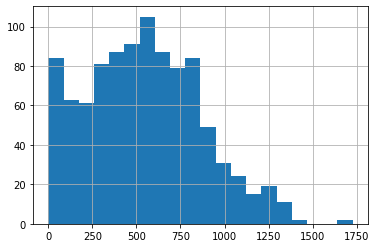

Среднее: 543.97
Дисперсия: 106122.45
Стандартное отклонение: 325.76

messages_count


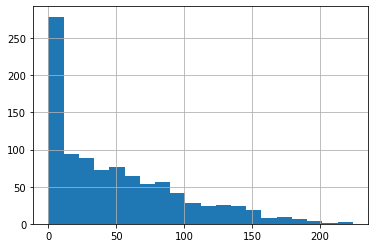

Среднее: 49.59
Дисперсия: 2301.92
Стандартное отклонение: 47.98

mb_used


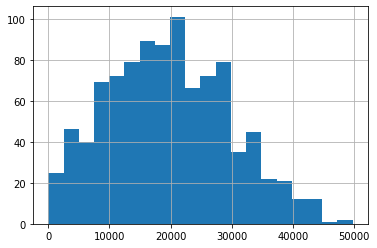

Среднее: 19668.49
Дисперсия: 98864248.95
Стандартное отклонение: 9943.05



In [14]:
def plot_hist(data):
    data = data.dropna()
    data.hist(bins=20, range=(data.min(), data.max()))
    plt.show()
    
def print_statistics(data):
    print('Среднее: {:.2f}'.format(data.mean()))
    print('Дисперсия: {:.2f}'.format(np.var(data, ddof=1)))
    print('Стандартное отклонение: {:.2f}'.format(np.std(data, ddof=1)))
    print()

columns = ['duration', 'messages_count', 'mb_used']

for column in columns:
    print(column)
    plot_hist(users_data_extended.loc[users_data_extended['tariff'] == 'ultra'][column])
    print_statistics(users_data_extended.loc[users_data_extended['tariff'] == 'ultra'][column])    

+ Гистограммы по израсходованным минутам и мегабайтам имеют около нормальное распределение (при увеличении выборки становилось бы более приближенным к нормальному).
+ Все пользователи тарифа "Ультра" полностью не используют пакет минут и сообщений. Предложение избыточно.
+ По гистограмме сообщений видно, что они не пользуются большим спросом в наше время. Связано с обширным распространением мобильного интернета и ростом популярности приложений мессенджеров.
+ Выбивающиеся пики для околонулевых значений (гистограммы минут и сообщений) говорит о том, что есть категория пользователей, которые пользуются только интернетом.

### Тариф "Смарт"

duration


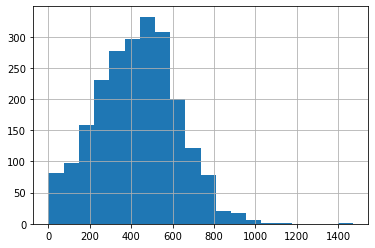

Среднее: 429.62
Дисперсия: 37927.14
Стандартное отклонение: 194.75

messages_count


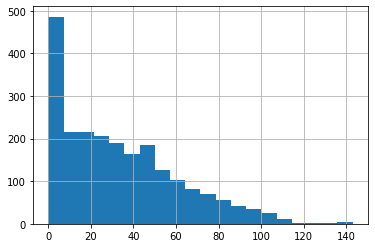

Среднее: 33.40
Дисперсия: 796.70
Стандартное отклонение: 28.23

mb_used


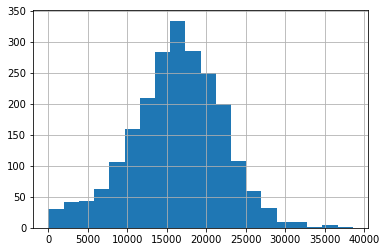

Среднее: 16215.66
Дисперсия: 34359951.68
Стандартное отклонение: 5861.74



In [15]:
for column in columns:
    print(column)
    plot_hist(users_data_extended.loc[users_data_extended['tariff'] == 'smart'][column])
    print_statistics(users_data_extended.loc[users_data_extended['tariff'] == 'smart'][column])  

## 4. Проверка гипотез

+ Пользователи, попавшие в наше исследование это выборка из генеральной совокупности - всех пользователей "Мегалайн", использующих тарифы "Смарт" и "Ультра".
+ Нулевая гипотеза формулировалась так, чтобы использовать знак равенства, альтернативная гипотеза сформулирована как двухсторонняя.
+ Уровень статистической значимости выбран в 5% (параметр alpha)

##### Средняя выручка для тарифов "Смарт" и "Ультра"

$H_0$ - средняя выручка для тарифов не отличаются  
$H_1$ - средняя выручка различается

In [16]:
print('Средняя выручка для тарифа "Ультра": {:.2f} рублей'.format(users_data_extended[users_data_extended['tariff'] == 'ultra']['revenue'].mean()))
print('Средняя выручка для тарифа "Смарт": {:.2f} рублей'.format(users_data_extended[users_data_extended['tariff'] == 'smart']['revenue'].mean()))
print()
alpha = .05
results = st.ttest_ind(
    users_data_extended[users_data_extended['tariff'] == 'ultra']['revenue'],
    users_data_extended[users_data_extended['tariff'] == 'smart']['revenue'],
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка для тарифа "Ультра": 2071.38 рублей
Средняя выручка для тарифа "Смарт": 1307.29 рублей

p-значение: 4.781366758865783e-237
Отвергаем нулевую гипотезу


+ Средняя выручка от тарифа "Ультра" и от тарифа "Смарт" различается

##### Средняя выручка от пользователей в Москве и других регионах

$H_0$ - средняя выручка от пользователей из Москвы и из других регионах не отличается  
$H_1$ - средняя выручка различается

In [17]:
print('Средняя выручка от пользователей из Москвы: {:.2f} рублей'.format(users_data_extended.loc[users_data_extended['city'] == 'Москва', 'revenue'].mean()))
print('Средняя выручка от пользователей из других регионов: {:.2f} рублей'.format(users_data_extended.loc[users_data_extended['city'] != 'Москва', 'revenue'].mean()))
print()
alpha = .05
results = st.ttest_ind(
    users_data_extended[users_data_extended['city'] == 'Москва']['revenue'],
    users_data_extended[users_data_extended['city'] != 'Москва']['revenue'],
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка от пользователей из Москвы: 1556.47 рублей
Средняя выручка от пользователей из других регионов: 1535.97 рублей

p-значение: 0.5514322920629973
Не получилось отвергнуть нулевую гипотезу


+ Средняя выручка от пользователей, живущих в разных регионах статистически не различается.

## 5. Общие выводы

1. Средняя выручка от тарифа "Ультра" больше, чем от тарифа "Смарт.
1. Средняя выручка от пользователей, проживающих в Москве и в других регионах одинаковая.
1. Средний пользователь с тарифом "Ультра" не использует полностью предоставляемый пакет услуг. Тариф является избыточным.
1. Средний пользователь с тарифом "Смарт" использует услуги в количестве близком к размеру пакета. Тариф для них является оптимальным.

Тариф "Ультра" приносит больше выручки, но для большинства пользователей он избыточен, они полностью не используют пакет услуг. Через какое-то время для оптимизации расходов они перейдут на другие тарифы или к конкурентам. Однако не стоит забывать о пользователях которые используют много интернет-трафика, для них этот тариф будет приемлимым. Следует несколько скорректировать объём услуг в пакете.  
Пакет услуг в тарифе "Смарт" для пользователей подобран удачно, он удовлетворяет потребностям пользаветелей, выбравшим его.  
Нельзя сказать какой тариф лучше или хуже. Разные пользователи - разные потребности и чтобы они не уходили к конкурентам компании "Мегалайн" следует сохранить оба тарифа.